In [1]:
import csv
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error as MSLE
random.seed(123)
plt.rcParams["font.sans-serif"]=["SimHei"]
from datetime import datetime
pd.set_option("display.max_rows", 1000)    #設定最大能顯示1000rows
pd.set_option("display.max_columns", 1000) #設定最大能顯示1000columns
path = r"C:\Users\user\Desktop\ETC"

In [2]:
acc_1_fin=pd.read_csv(path+r"/acc_1_fin.csv")
print(acc_1_fin.columns)
print(acc_1_fin.shape)

Index(['Unnamed: 0', '回堵情況', '總通行量', '總平均車速', '里程數', '速限', '24小時內死亡人數',
       '2-30日內死亡人數', '受傷人數', '事故涉及車輛數',
       ...
       '肇因研判(子)_22', '肇因研判(子)_23', '肇因研判(子)_24', '肇因研判(子)_25', '肇因研判(子)_26',
       '肇因研判(子)_27', '肇因研判(子)_28', '是否為連續假日_1', '是否為假日_1', '處理時間'],
      dtype='object', length=281)
(7252, 281)


In [3]:
X1 = acc_1_fin.drop("處理時間",axis = 1)
y1 = acc_1_fin["處理時間"]

In [4]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2) # 0.2 test_size means 20%

##  Lasso

In [5]:
# LASSO交叉检验 cv=10

lassocv_1 = LassoCV(alphas=None, copy_X=True, cv=10, eps=0.0001, fit_intercept=True,
max_iter=50000, n_alphas = 1000 , n_jobs=1, normalize=False, positive=False,
precompute='auto', random_state=None, selection='cyclic', tol=0.0001,verbose=False)
lassocv_1.fit(X1_train, y1_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.0001, fit_intercept=True,
        max_iter=50000, n_alphas=1000, n_jobs=1, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [6]:
lasso_best_alpha = lassocv_1.alpha_
print('最佳的alpha : ',lasso_best_alpha)
print('估計係數個數 : ',len(lassocv_1.coef_ ))
print('非0的係數個數 : ',np.sum(lassocv_1.coef_ != 0))
#print("系数：",lassocv_1.coef_)

最佳的alpha :  0.08919002398414959
估計係數個數 :  280
非0的係數個數 :  41


In [17]:
# train model
lasso_1=Lasso(alpha =  lassocv_1.alpha_ , max_iter = 50000 , tol = 0.0001 , normalize=False)
lasso_1.fit(X1_train,y1_train)

#prediction
lasso_1_pred=lasso_1.predict(X1_test)
lasso_1_pred=lasso_1_pred.flatten()

# msle
#print(MSLE(lasso_1_pred,y1_test,))
# rmse
print(np.sqrt(mean_squared_error(y1_test,lasso_1_pred)))
# mse
print(mean_squared_error(y1_test,lasso_1_pred))

# r2
print(metrics.r2_score(y1_test,lasso_1_pred))

12.782100794101122
163.38210071056056
0.29784540199205034


## 係數視覺化

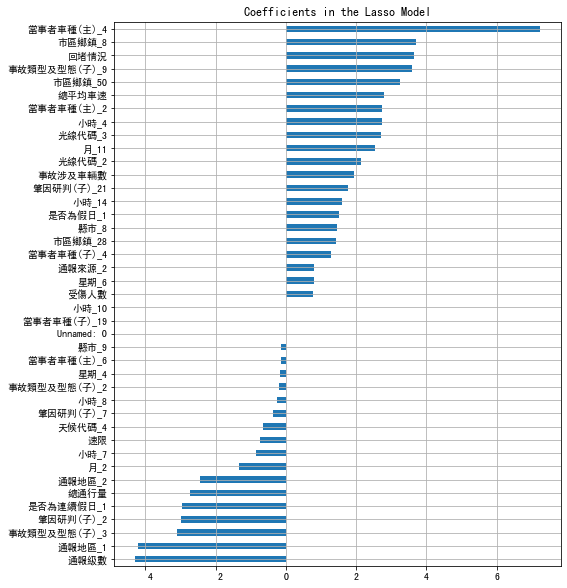

In [9]:
coef = pd.Series( lassocv_1.coef_, index = X1_train.columns)
imp_coef = pd.concat([coef.sort_values().head(20), coef.sort_values().tail(21)])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh",grid=True)
plt.title("Coefficients in the Lasso Model")
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


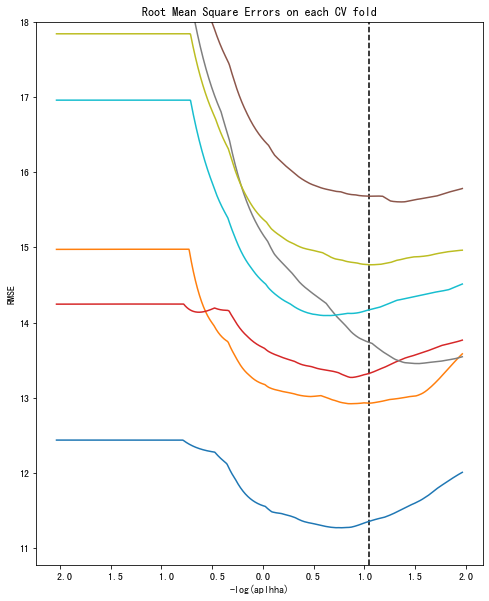

In [10]:
# Display results
m_log_alphas = -np.log10(lassocv_1.alphas_)
m_log_alpha = -np.log10(lassocv_1.alpha_)
ax = plt.gca()
#ax.set_color_cycle(2 * ['b', 'r', 'g', 'c', 'k'])
ymin, ymax = np.sqrt(lassocv_1.mse_path_.min())-0.5,18
plt.plot(m_log_alphas, np.sqrt(lassocv_1.mse_path_))
plt.vlines([m_log_alpha], ymin, ymax, linestyle='dashed')

plt.xlabel('-log(aplhha)')
plt.ylabel('RMSE')
plt.title('Root Mean Square Errors on each CV fold')
plt.axis('tight')
plt.ylim(ymin, ymax)
plt.show()

## Dimension Reduction BY LASSO

In [11]:
variable_select_varname=acc_1_fin.columns[np.where(lassocv_1.coef_!=0)]

In [21]:
print(variable_select_varname)
print(len(variable_select_varname))

Index(['Unnamed: 0', '回堵情況', '總通行量', '總平均車速', '速限', '受傷人數', '事故涉及車輛數', '通報級數',
       '通報地區_1', '通報地區_2', '通報來源_2', '縣市_8', '縣市_9', '市區鄉鎮_8', '市區鄉鎮_28',
       '市區鄉鎮_50', '市區鄉鎮_75', '當事者車種(子)_4', '月_2', '月_11', '星期_4', '星期_6',
       '小時_4', '小時_7', '小時_8', '小時_14', '天候代碼_4', '天候代碼_5', '光線代碼_2', '光線代碼_3',
       '事故類型及型態(子)_2', '事故類型及型態(子)_3', '事故類型及型態(子)_9', '當事者車種(主)_2',
       '當事者車種(主)_4', '當事者車種(主)_6', '肇因研判(子)_2', '肇因研判(子)_7', '肇因研判(子)_21',
       '是否為連續假日_1', '是否為假日_1'],
      dtype='object')
41


In [23]:
with open(file=path+r'\variable_select_varname.lst',mode="wb") as outhis : 
                                                    
    pickle.dump(variable_select_varname, outhis)